In [43]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

from xgboost import XGBRFClassifier

from sklearn.pipeline import Pipeline

from imblearn.over_sampling import RandomOverSampler

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from yellowbrick.classifier import ConfusionMatrix, ROCAUC


# Import labeled data

In [2]:
labeled_df = pd.read_csv("../data/user_labeled/final_labeled.csv")
print(labeled_df.label.value_counts())
labeled_df

after     211
before    121
Name: label, dtype: int64


,node,label,degree,category_matches_with_source,in_edges,out_edges,shared_neighbors_with_entry_score,centrality,page_rank,adjusted_reciprocity,shortest_path_length_from_entry,shortest_path_length_to_entry,jaccard_similarity,primary_link,similarity_rank
0,StarCraft II: Heart of the Swarm,after,0.010420,1.000000,0.005118,0.043292,0.320449,0.592755,0.002671,0.056061,0.166667,0.20,0.247350,0.0,1.000000
1,StarCraft (video game),before,0.017115,0.916667,0.005065,0.095554,0.196211,1.000000,0.003881,0.087879,0.166667,0.20,0.252669,1.0,0.905361
2,StarCraft: Brood War,before,0.011578,0.833333,0.006120,0.044852,0.202199,0.648033,0.002642,0.053030,0.166667,0.20,0.203883,0.0,0.816960
3,StarCraft II: Legacy of the Void,after,0.008859,0.750000,0.004221,0.037832,0.294207,0.542680,0.001999,0.048485,0.166667,0.20,0.208633,0.0,0.775480
4,StarCraft II: Wings of Liberty,after,0.021544,0.083333,0.013506,0.067473,1.000000,0.995219,0.007313,0.110606,0.000000,0.00,1.000000,0.0,0.548565
5,Jim Raynor,after,0.003977,0.000000,0.002163,0.015211,0.109752,0.088870,0.000506,0.034848,0.166667,0.20,0.133588,1.0,0.101773
6,List of StarCraft media,after,0.006393,0.083333,0.001741,0.037051,0.123632,0.131356,0.000439,0.033333,0.166667,0.20,0.128906,0.0,0.099830
7,Races of StarCraft,before,0.008557,0.083333,0.003218,0.042902,0.134990,0.144347,0.001264,0.036364,0.166667,0.20,0.182836,0.0,0.097667
8,Real-time strategy,before,0.080439,0.083333,0.068271,0.118955,0.042367,0.268845,0.040270,0.271212,0.166667,0.20,0.031271,1.0,0.084069
9,StarCraft,before,0.032468,0.083333,0.019363,0.108814,0.193881,0.316930,0.011237,0.121212,0.166667,0.20,0.198077,0.0,0.078426


# Exploration - PCA Plotting

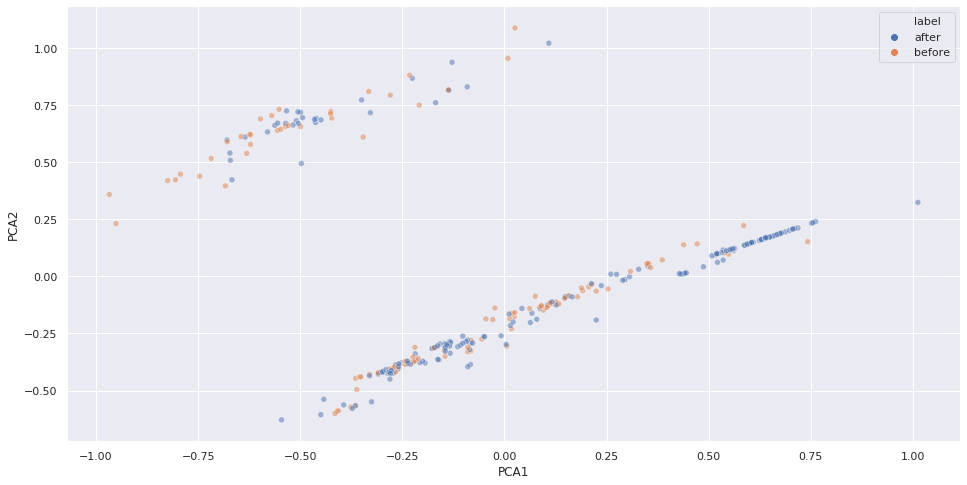

In [3]:
pca = PCA(n_components = 2, )

components_df = pd.DataFrame(pca.fit_transform(labeled_df.drop(["node", "label"], axis=1)),
                            columns=["PCA1", "PCA2"])

components_df['label'] = labeled_df['label']

# components_df = components_df[components_df.PCA1 > 0.2]

# components_df.label.value_counts()

plt.figure(figsize=(16,8))
sns.scatterplot(data=components_df, x="PCA1", y='PCA2', hue='label', alpha=0.5)

# Test Train Split

In [80]:
X = labeled_df.drop([
    "node", 
    "label", 
    "similarity_rank",
    
    # trimming less valuable estimators
    "shortest_path_length_to_entry",
    "primary_link",
    "category_matches_with_source",
#     "shortest_path_length_from_entry",
#     "in_edges",
#     "adjusted_reciprocity",
    
], axis=1)
y = labeled_df.label

cols = X.columns 

ros = RandomOverSampler()
# X, y = ros.fit_sample(X, y)

# X = pd.DataFrame(X, columns=cols)
# y = pd.Series(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

X_train, y_train = ros.fit_sample(X_train, y_train)
X_train = pd.DataFrame(X_train, columns=cols)
y_train = pd.Series(y_train)

X_test, y_test = ros.fit_sample(X_test, y_test)
X_test = pd.DataFrame(X_test, columns=cols)
y_test = pd.Series(y_test)

print("Train Classes:")
print(y_train.value_counts(), "\n")
print("Test Classes:")
print(y_test.value_counts(), "\n")

Train Classes:
after     166
before    166
dtype: int64 

Test Classes:
before    45
after     45
dtype: int64 



# Random Forest

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished


Train Score:	 0.8403614457831325
Test Score:	 0.7444444444444445


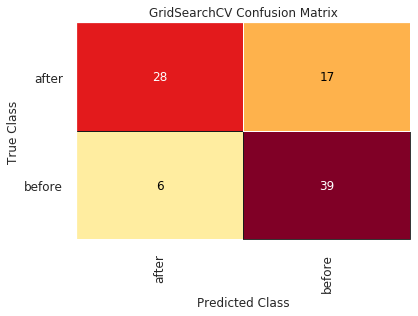

Best Params:	 {'rf__criterion': 'entropy', 'rf__max_depth': 10, 'rf__max_leaf_nodes': 8, 'rf__min_samples_leaf': 10, 'rf__min_samples_split': 5, 'rf__n_estimators': 100}


In [116]:
rf = RandomForestClassifier(n_jobs=-1, random_state=42)
pca = PCA()

# pipeline steps
steps = [
#     ("pca", pca),
    ("rf", rf)
]

pipe = Pipeline(steps)

# GridSearch params
params = {
#     "pca__n_components": [4,5,6,7,8,9],
    
    "rf__criterion": ["entropy"],
    "rf__n_estimators": [100],
    "rf__max_depth": [10],
    "rf__min_samples_split": [5],
    "rf__min_samples_leaf": [10],
    "rf__max_leaf_nodes": [8], 
    
}

rf_model = GridSearchCV(pipe, params, n_jobs=-1, cv=3, verbose=2)

rf_model.fit(X_train, y_train)

cm = ConfusionMatrix(rf_model, classes=["after", "before"], is_fitted=True)

print("Train Score:\t", rf_model.score(X_train, y_train))
print("Test Score:\t", cm.score(X_test, y_test))
cm.poof()
print("Best Params:\t", rf_model.best_params_)

In [117]:

best_estimators = pd.DataFrame(list(zip(X_train.columns, gs_model.best_estimator_.feature_importances_)), 
             columns=["Feature", "Estimation Strength"])

best_estimators.sort_values("Estimation Strength", ascending=False)

,Feature,Estimation Strength
5,page_rank,0.308972
3,shared_neighbors_with_entry_score,0.211393
8,jaccard_similarity,0.112195
0,degree,0.084916
7,shortest_path_length_from_entry,0.078001
6,adjusted_reciprocity,0.071236
1,in_edges,0.048125
4,centrality,0.043595
2,out_edges,0.041567


# XG Boost

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  54 | elapsed:    0.1s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:    0.7s finished


Train Score:	 0.9186746987951807
Test Score:	 0.7333333333333333


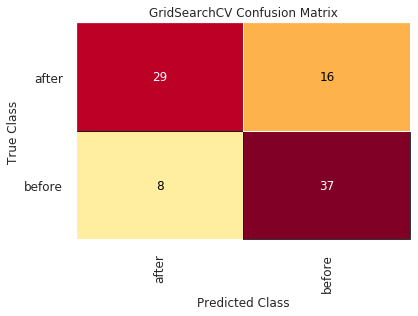

Best Params:	 {'gamma': 0, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200}


In [138]:
model = XGBRFClassifier(random_state=10, )

params = { 
    "max_depth": [i for i in range(1, 10)],
    "n_estimators": [100, 200],
    "learning_rate": [0.01],
    "gamma": [0]
}

xg_model = GridSearchCV(model, params, n_jobs=-1, cv=3, verbose=2)

xg_model.fit(X_train, y_train)

cm = ConfusionMatrix(xg_model, classes=["after", "before"], is_fitted=True)

print("Train Score:\t", xg_model.score(X_train, y_train))
print("Test Score:\t", cm.score(X_test, y_test))
cm.poof()
print("Best Params:\t", xg_model.best_params_)

# SVM

Fitting 10 folds for each of 384 candidates, totalling 3840 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 3136 tasks      | elapsed:    4.4s


0.6666666666666666


[Parallel(n_jobs=-1)]: Done 3840 out of 3840 | elapsed:    5.4s finished
/home/qdizon/.local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


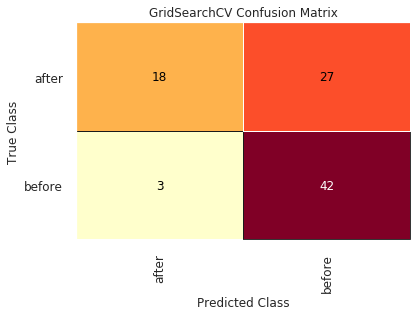

In [83]:
pca = PCA()
model = SVC()

steps = [
    ("pca", pca),
    ("svm", model)
]

pipe = Pipeline(steps)

params = {
    "pca__n_components": [2,3,4,5], 
    
    "svm__C": [0.001, 0.01, 0.1, 1, 10, 15],
    "svm__kernel": ['linear', 'poly', 'rbf', 'sigmoid'],
    "svm__decision_function_shape": ['ovo', 'ovr'],
    "svm__shrinking": [True, False]
}

svc_model = GridSearchCV(pipe, params, n_jobs=-1, cv=10, verbose=2)

cm = ConfusionMatrix(svc_model, classes=["after", "before"])
cm.fit(X_train, y_train)

print(cm.score(X_test, y_test))

cm.poof()

# KNN

Fitting 3 folds for each of 176 candidates, totalling 528 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 528 out of 528 | elapsed:    6.5s finished
/home/qdizon/.local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.6333333333333333


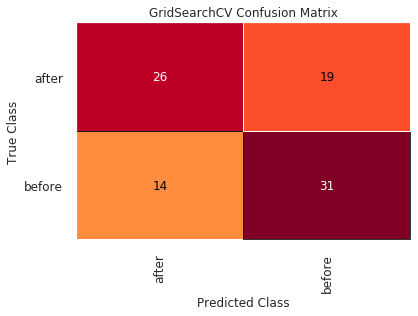

In [84]:
pca = PCA()
knn = KNeighborsClassifier(n_jobs=-1,)

steps = [
    ("pca", pca),
    ("knn", knn)
]

pipe = Pipeline(steps)

params = {
    "pca__n_components": [2,3,4,5], 
    
    "knn__n_neighbors": [k for k in range(5, 26) if k % 2 != 0],
    "knn__metric": ['minkowski', "euclidean", "chebyshev", "wminkowski"]
}

knn_model = GridSearchCV(pipe, params, n_jobs=-1, cv=3, verbose=2, scoring="accuracy", error_score=0.0)

cm = ConfusionMatrix(knn_model, classes=["after", "before"])
cm.fit(X_train, y_train)

print(cm.score(X_test, y_test))

cm.poof()

# Adaboost